## Cardio Logistic Model

In [1]:
# seed value for random number generators to obtain reproducible results
#RANDOM_SEED = 1
#random seed is set to 42 in train/test split

# import base packages 
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns  # pretty plotting, including heat map
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.preprocessing import binarize
from sklearn.metrics import precision_recall_curve
from sklearn.naive_bayes import BernoulliNB
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score
import math


## Defined functions

In [2]:
# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      

np.set_printoptions(precision=3)

In [3]:
# define a function to return model metrics for evaluation

def model_metrics(y_known, y_pred):
    y_test = y_known
    y_pred_class = y_pred
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    class_error = 1 - metrics.accuracy_score(y_test, y_pred_class)
    sensitivity = metrics.recall_score(y_test, y_pred_class)
    specificity = TN / (TN + FP)
    false_positive_rate = FP / float(TN + FP)
    precision = TP / float(TP + FP)
    f1_score = metrics.f1_score(y_test, y_pred_class)
#    F1 = 2*precision*sensitivity/(precision + sensitivity)
    print('The model metrics are:',
         '\naccuracy:', accuracy,
         '\nclassification error:', class_error,
         '\nsensitivity:', sensitivity,
         '\nspecificity:', specificity,
         '\nfalse positive rate:', false_positive_rate,
         '\nprecision:', precision,
          '\nF1 score:', f1_score,
#          '\nF1 by hand:', F1,
         '\nconfusion matrix:')
    return(confusion)



In [4]:
# define a function that accepts a threshold and 
# prints sensitivity and specificity

def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [5]:
# define a function that accepts the fpr and tpr values 
# from the roc_curve function and plot the ROC curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for response')


In [6]:
# define a function that accepts the recall and precision values 
# from the precision_recall_curve function and plot the PR curve

def plot_pr_curve(recall, precision, label=None):
    plt.plot(recall, precision, linewidth=2, label=label)
#    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR curve for response')

## Import data set and prepare for analysis

In [7]:
# initial work with the smaller data set
X_test = pd.read_csv('cardio_x_test.csv', sep = ',', encoding = 'unicode_escape')  
X_train = pd.read_csv('cardio_x_train.csv', sep = ',', encoding = 'unicode_escape')  
y_test = pd.read_csv('cardio_y_test.csv', sep = ',', encoding = 'unicode_escape')  
y_train = pd.read_csv('cardio_y_train.csv', sep = ',', encoding = 'unicode_escape')
# examine the shape of original input data
print('The shape of the X test set is: ', X_test.shape)
print('The shape of the X train set is: ',X_train.shape)
print('The shape of the Y test set is: ',y_test.shape)
print('The shape of the Y train set is: ',y_train.shape)

The shape of the X test set is:  (13750, 24)
The shape of the X train set is:  (54997, 24)
The shape of the Y test set is:  (13750, 2)
The shape of the Y train set is:  (54997, 2)


In [8]:
#drop unnecessary columns for model
X_train = X_train.drop(['Unnamed: 0', 'id', 'age_days', 'LATITUDE',
                 'LONGITUDE','ZIP','FACILITY_NAME','ADDRESS',
                 'CITY','STATE','DESCRIPTION','FACILITY_TYPE' ], axis=1)
X_test = X_test.drop(['Unnamed: 0', 'id', 'age_days', 'LATITUDE',
                 'LONGITUDE','ZIP','FACILITY_NAME','ADDRESS',
                 'CITY','STATE','DESCRIPTION','FACILITY_TYPE' ], axis=1)
y_train = y_train.drop(['Unnamed: 0'], axis=1)
y_test = y_test.drop(['Unnamed: 0'], axis=1)    


In [9]:
y_train = y_train.rename(columns={"x": "cardio"})
y_test = y_test.rename(columns={"x": "cardio"})

In [10]:
#total number of NaN values in each column
print('The total number of NaN values in the X test set is:\n', X_test.isnull().sum())
print('The total number of NaN values in the X train set is:\n',X_train.isnull().sum())
print('The total number of NaN values in the Y test set is:\n',y_test.isnull().sum())
print('The total number of NaN values in the Y train set is:\n',y_train.isnull().sum())


The total number of NaN values in the X test set is:
 age_years      0
gender         0
height_cm      0
weight_kg      0
BMI            0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alcohol        0
active         0
dtype: int64
The total number of NaN values in the X train set is:
 age_years      0
gender         0
height_cm      0
weight_kg      0
BMI            0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alcohol        0
active         0
dtype: int64
The total number of NaN values in the Y test set is:
 cardio    0
dtype: int64
The total number of NaN values in the Y train set is:
 cardio    0
dtype: int64


In [11]:
X_train.head()

,age_years,gender,height_cm,weight_kg,BMI,ap_hi,ap_lo,cholesterol,gluc,smoke,alcohol,active
0,62,female,160,101.0,39.453125,120,70,1,1,0,0,1
1,41,male,172,78.0,26.365603,140,80,1,1,0,0,1
2,57,female,168,80.0,28.344671,140,90,1,1,0,0,1
3,52,female,161,75.0,28.934069,110,80,2,3,0,0,1
4,39,female,169,64.0,22.408179,100,70,1,1,0,0,1


In [12]:
# mapping function to convert text female/male to integer 1/2
convert_to_binary = {'female' : 1, 'male' : 2}

# define binary variable for gender
X_train['gender'] = X_train['gender'].map(convert_to_binary)
X_test['gender'] = X_test['gender'].map(convert_to_binary)

In [13]:
X_train.head()

,age_years,gender,height_cm,weight_kg,BMI,ap_hi,ap_lo,cholesterol,gluc,smoke,alcohol,active
0,62,1,160,101.0,39.453125,120,70,1,1,0,0,1
1,41,2,172,78.0,26.365603,140,80,1,1,0,0,1
2,57,1,168,80.0,28.344671,140,90,1,1,0,0,1
3,52,1,161,75.0,28.934069,110,80,2,3,0,0,1
4,39,1,169,64.0,22.408179,100,70,1,1,0,0,1


In [14]:
y_train.head()


,cardio
0,1
1,0
2,1
3,0
4,0


## Split the data into train and test sets

In [15]:
#this can be deleted later, was here to create data set with cardio data



In [16]:
# read csv file into a dataframe
#cardio = pd.read_csv('Cardio_train_clean.csv', sep = ',')  
# examine the shape of original input data
#print(cardio.shape)

#cardio.head()

In [17]:
#cardio = cardio.drop(['id', 'age_days', 'height_m',
#                     'height_inches', 'height_feet', 'weight_lb'], axis=1)

In [18]:
#split data and response 

#model_data_df_X = cardio.drop('cardio', axis=1)
#model_data_df_y = cardio.cardio.copy()

In [19]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(
#   model_data_df_X, model_data_df_y, test_size=0.2, random_state=42)

## Logistic Regression Model, C = 100

In [20]:
# Create a logistic regression model on the data
# C is the hyperparameter controlling the regularization 
# strength of a Scikit-Learn LogisticRegression model.
# The higher the value of C, the less the model is regularized.

# Instantiate model
log_reg100 = LogisticRegression(C=100, max_iter=4000)

# Fit the model
log_reg100.fit(X_train, y_train.values.ravel())

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
# make predictions for the testing set
y_predictions100 = log_reg100.predict(X_test)

In [22]:
# look at the first 10 entries for predictions
y_predictions100[0:10]

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [23]:
# look at the first 10 entries for the true values
y_test[0:10]

,cardio
0,0
1,0
2,0
3,0
4,1
5,1
6,1
7,1
8,1
9,1


In [24]:
# make predicted probabilities for the predictions
y_predict_prob100 = log_reg100.predict_proba(X_test)

In [25]:
# Look at the first ten rows of predicted probabilities 
# of response class membership.
# The first column is the predicted probability that the
# observation is a member of class 0.
# The second column is the predicted probability that the
# observation is a member of class 1. 

y_predict_prob100[0:10]

array([[0.794, 0.206],
       [0.844, 0.156],
       [0.872, 0.128],
       [0.514, 0.486],
       [0.32 , 0.68 ],
       [0.052, 0.948],
       [0.432, 0.568],
       [0.371, 0.629],
       [0.145, 0.855],
       [0.493, 0.507]])

In [26]:
# the first argument is true values, 
# the second argument is predicted values
# this produces a 2x2 numpy array (matrix)

confusion100 = metrics.confusion_matrix(y_test, y_predictions100)
print(confusion100)

[[5461 1506]
 [2270 4513]]


In [27]:
# precision, recall, F1 score, and count of response variable
# of logistic regression model, C =100 when threshold set to 0.5

print(classification_report(y_test, y_predictions100))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      6967
           1       0.75      0.67      0.71      6783

    accuracy                           0.73     13750
   macro avg       0.73      0.72      0.72     13750
weighted avg       0.73      0.73      0.72     13750



## Adjusting the classification threshold

In [28]:
# store the predicted probabilities for class 1 of the response
# for the logistic regression, C = 100 model
y_pred_prob100_class1 = log_reg100.predict_proba(X_test)[:,1]

In [29]:
# look at the first ten entries for predicted
# probabilities for class 1 
y_pred_prob100_class1[0:10]

array([0.206, 0.156, 0.128, 0.486, 0.68 , 0.948, 0.568, 0.629, 0.855,
       0.507])

In [30]:
# the default threshold for predicted probabilities to be classified
# as 0 or 1 is 0.5
# let's see what would happen if the default is set to 0.45
# predict response if the predicted probability is greater than 0.45
# it will return 1 for all values above 0.45 and 0 otherwise
# results are 2D so we slice out the first column

y_pred_class100 = binarize(y_pred_prob100_class1.reshape(-1, 1), 0.45)

In [31]:
# print the first 10 predicted classes with the lower threshold
y_pred_class100[0:10]

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [32]:
# previous confusion matrix (default threshold of 0.5)
print(confusion100)

[[5461 1506]
 [2270 4513]]


In [33]:
# new confusion matrix (threshold set to 0.45)

confusion100_threshold1 = metrics.confusion_matrix(y_test, y_pred_class100)
print(confusion100_threshold1)

[[4990 1977]
 [1804 4979]]


In [34]:
# precision, recall, F1 score, and count of response variable
# of logistic regression model, C =100 when threshold set to 0.45

print(classification_report(y_test, y_pred_class100))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73      6967
           1       0.72      0.73      0.72      6783

    accuracy                           0.73     13750
   macro avg       0.73      0.73      0.73     13750
weighted avg       0.73      0.73      0.73     13750



In [35]:
# evaluate logistic regression model, C = 100
# when threshold set to 0.45

model_metrics(y_test, y_pred_class100)

The model metrics are: 
accuracy: 0.7250181818181818 
classification error: 0.2749818181818182 
sensitivity: 0.7340409848149786 
specificity: 0.7162336730299985 
false positive rate: 0.2837663269700014 
precision: 0.7157849338700403 
F1 score: 0.7247980202343693 
confusion matrix:


array([[4990, 1977],
       [1804, 4979]])

In [36]:
# evaluate logistic regression model, C = 100
# when threshold set to default 0.5

model_metrics(y_test, y_predictions100)

#y_predictions100 is the predicted response value

The model metrics are: 
accuracy: 0.7253818181818181 
classification error: 0.2746181818181819 
sensitivity: 0.6653398201385817 
specificity: 0.7838380938711067 
false positive rate: 0.21616190612889336 
precision: 0.7497923243063632 
F1 score: 0.7050460865489767 
confusion matrix:


array([[5461, 1506],
       [2270, 4513]])

Best results obtained with threshold set to default of 0.5

## Grid Search 

In [37]:
from sklearn.model_selection import GridSearchCV

# GridSearchCV: specify which hyperparameters you want
# it to experiment with, and what values to try out, 
# and it will evaluate all the possible combinations 
# of hyperparameter values, using cross-validation


param_grid = [
    {'C': [0.1, 0.5, 1, 10, 100], 'max_iter':[4000,10000,15000]},
  ]

logistic_gs = LogisticRegression()

grid_search = GridSearchCV(logistic_gs, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.1, 0.5, 1, 10, 100],
                          'max_iter': [4000, 10000, 15000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [38]:
print('\n----------------------------')
print('The parameters choosen by Grid Search for Logistic Regression:\n ')
grid_search.best_params_


----------------------------
The parameters choosen by Grid Search for Logistic Regression:
 


{'C': 0.5, 'max_iter': 4000}

In [39]:
grid_search.best_estimator_

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print('Mean RMSE:', np.sqrt(-mean_score), params)
    
# a smaller RMSE value is preferred

Mean RMSE: 0.5243493848543342 {'C': 0.1, 'max_iter': 4000}
Mean RMSE: 0.5243493848543342 {'C': 0.1, 'max_iter': 10000}
Mean RMSE: 0.5243493848543342 {'C': 0.1, 'max_iter': 15000}
Mean RMSE: 0.5240719019256352 {'C': 0.5, 'max_iter': 4000}
Mean RMSE: 0.5240719019256352 {'C': 0.5, 'max_iter': 10000}
Mean RMSE: 0.5240719019256352 {'C': 0.5, 'max_iter': 15000}
Mean RMSE: 0.5242800302551981 {'C': 1, 'max_iter': 4000}
Mean RMSE: 0.5242800302551981 {'C': 1, 'max_iter': 10000}
Mean RMSE: 0.5242800302551981 {'C': 1, 'max_iter': 15000}
Mean RMSE: 0.5243147087015155 {'C': 10, 'max_iter': 4000}
Mean RMSE: 0.5243147087015155 {'C': 10, 'max_iter': 10000}
Mean RMSE: 0.5243147087015155 {'C': 10, 'max_iter': 15000}
Mean RMSE: 0.5243840681711635 {'C': 100, 'max_iter': 4000}
Mean RMSE: 0.5243840681711635 {'C': 100, 'max_iter': 10000}
Mean RMSE: 0.5243840681711635 {'C': 100, 'max_iter': 15000}


## Logistic Regression Model, C = 0.5

In [41]:
# Create a logistic regression model on the data
# C is the hyperparameter controlling the regularization 
# strength of a Scikit-Learn LogisticRegression model.
# The higher the value of C, the less the model is regularized.

# Instantiate model
log_reg_5 = LogisticRegression(C=0.5, max_iter=4000)

# Fit the model
lr = log_reg_5.fit(X_train, y_train.values.ravel())

print('\n----------------------------')
print('Logistic Regression\n')
print(lr)
#print('intercept:', lr_intercept)
#print('coefficients:', lr_coef)


----------------------------
Logistic Regression

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [42]:
# make predictions for the testing set
y_predictions_5 = log_reg_5.predict(X_test)

In [43]:
# make predicted probabilities for the predictions
y_predict_prob_5 = log_reg_5.predict_proba(X_test)

In [44]:
# the first argument is true values, 
# the second argument is predicted values
# this produces a 2x2 numpy array (matrix)

confusion_5 = metrics.confusion_matrix(y_test, y_predictions_5)
print(confusion_5)

[[5468 1499]
 [2282 4501]]


In [45]:
# precision, recall, F1 score, and count of response variable
# of logistic regression model, C =0.5 when threshold set to 0.5

print(classification_report(y_test, y_predictions_5))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      6967
           1       0.75      0.66      0.70      6783

    accuracy                           0.73     13750
   macro avg       0.73      0.72      0.72     13750
weighted avg       0.73      0.73      0.72     13750



In [46]:
# evaluate logistic regression model, C = 0.5
# when threshold set to default 0.5

model_metrics(y_test, y_predictions_5)

#y_predictions100 is the predicted response value

The model metrics are: 
accuracy: 0.7250181818181818 
classification error: 0.2749818181818182 
sensitivity: 0.6635706914344686 
specificity: 0.7848428304865795 
false positive rate: 0.2151571695134204 
precision: 0.7501666666666666 
F1 score: 0.7042165375889854 
confusion matrix:


array([[5468, 1499],
       [2282, 4501]])

Confusion matrix, without normalization
[[5468 1499]
 [2282 4501]]
Normalized confusion matrix
[[0.7848 0.2152]
 [0.3364 0.6636]]


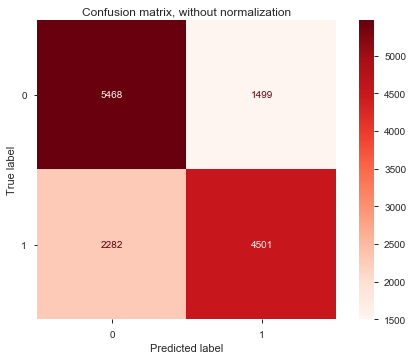

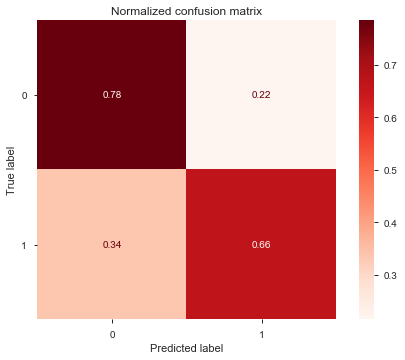

In [59]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
from sklearn.metrics import plot_confusion_matrix

target_names=['0', '1']
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None, "0.0f"),
                  ("Normalized confusion matrix", 'true', None)]
for title, normalize, values_format in titles_options:
    disp = plot_confusion_matrix(log_reg_5, X_test, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Reds,
                                 normalize=normalize,
                                 values_format=values_format,
                                )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    plt.grid(None)
    plt.savefig('Logistic {0}.png'.format(title))

    
plt.show()

In [48]:
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.73
Test set score: 0.73


## ROC Curve

In [49]:
# make predicted probabilities for the predictions
# logistic regression, C = 0.1
# store the predicted probabilities for class 1 of response

y_pred_prob_5_class1 = log_reg_5.predict_proba(X_test)[:, 1]

In [50]:
# the first argument is true values, 
# the second argument is predicted probabilities

# pass y_test and y_pred_prob
# do not use y_pred_class, because it will 
# give incorrect results without generating an error
# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_5_class1)

In [51]:
# a check of thresholds
thresholds

array([1.9995e+00, 9.9948e-01, 9.9865e-01, ..., 2.2522e-03, 2.0021e-03,
       1.6483e-03])

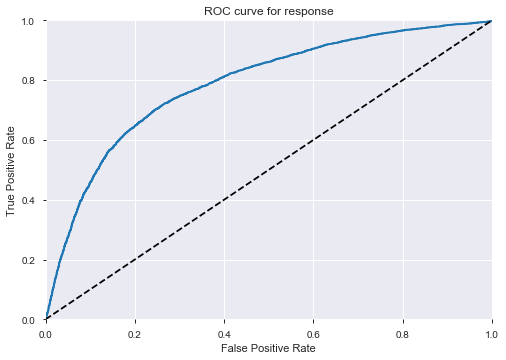

In [52]:
# plot the ROC curve for the logistic regression, C = 0.5
    
plot_roc_curve(fpr, tpr)
plt.savefig('ROC_logistic_C_5_plot.pdf')
plt.show()

In [53]:
# evaluate the logistic regression model, C = 0.5
# sensitivity and specificity when the threshold is set to 0.5

print('When the threshold is set to 0.5')
evaluate_threshold(0.5)

When the threshold is set to 0.5
Sensitivity: 0.6635706914344686
Specificity: 0.7848428304865795


In [54]:
# AUC is the percentage of the ROC plot that is underneath the curve
# first argument is true values, second argument is predicted probabilities
# AUC for logistic regression, C = 100

roc_auc_y_5_class1 = metrics.roc_auc_score(y_test, y_pred_prob_5_class1)

print('\nThe AUC is:', roc_auc_y_5_class1)


The AUC is: 0.78724691057933


## PR Curve

In [55]:
# let's see what the Precision-Recall curve looks like
# for the logistic regression model, C = 0.5

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_5_class1)

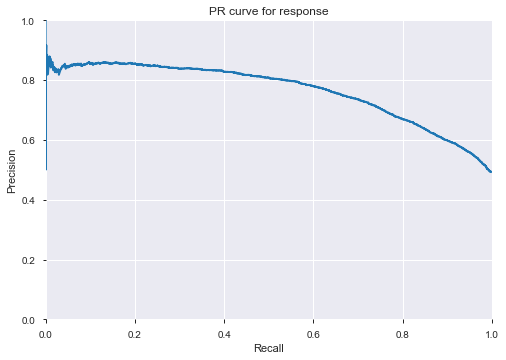

In [56]:
# plot the PR curve for logistic regression, C = 0.5
    
plot_pr_curve(recall, precision)
plt.savefig('PR_logistic_C_5_plot.pdf')
plt.show()

## Interpreting the Logistic Regression Model, C = 0.5

In [57]:
log_reg_5.coef_

array([[ 0.0512,  0.0029, -0.0707,  0.0823, -0.1876,  0.0477,  0.0204,
         0.511 , -0.1238, -0.1526, -0.1865, -0.2324]])

In [58]:
coeff_df = pd.DataFrame(X_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Coefficients"] = pd.Series(log_reg_5.coef_[0])

coeff_df.sort_values(by='Coefficients', ascending=False)


,Feature,Coefficients
7,gluc,0.510960
3,BMI,0.082324
0,gender,0.051238
5,ap_lo,0.047657
6,cholesterol,0.020387
1,height_cm,0.002872
2,weight_kg,-0.070750
8,smoke,-0.123785
9,alcohol,-0.152561
10,active,-0.186450
